## Multivariate analysis

## Data

In [1]:
import datetime
import time
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

##### Plotting

In [2]:
plt.figure(figsize = (6, 4))
sns.set_style("whitegrid", {'axes.linewidth': 1.5})
sns.set_context("notebook", font_scale = 1.5, rc = {"lines.linewidth": 2.5})
# context = talk

#### Wunderground - weather data

In [3]:
start_date = datetime.datetime(2011,9,1)
end_date = datetime.datetime(2017,3,1)
places = ['NYC', 'LONDON', 'RJTD']
# RJTD = Tokyo, Japan

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

nm_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
leap_years = [2012, 2016]

In [4]:
for place in places:
    start_time = time.time()
    exec("pres_low_{} = pd.Series()".format(place))
    exec("pres_avg_{} = pd.Series()".format(place))
    exec("pres_high_{} = pd.Series()".format(place))
    
    for i in range(0, (diff_month(end_date, start_date)) + 1):
        year = (start_date + relativedelta(months = +i)).year
        month = (start_date + relativedelta(months = +i)).month

        page = open('weather/{}/wunderground_{}_{}_{}.txt'.format(place, place, year, month), 'r')
        soup = BeautifulSoup(page, 'html.parser')

        table = soup.find('table', attrs = {"class" : "responsive obs-table daily"})
        rows = table.findAll('tr')

        monthly_history =[]
        for tr in rows:
            cols = tr.findAll('td')
            text_data = []
            for td in cols:
                monthly_history.append(td.text.strip())

        if year in leap_years and month == 2:
            days = nm_days[month - 1] + 1
        else:
            days = nm_days[month - 1]

        df = pd.DataFrame()
        labels = monthly_history[0:21]

        for row in range(1, (days + 1)):
            for col in range(0, 21):
                df.loc[row, col] = monthly_history[21*row + col]

        df.columns = labels

        df['year'] = year
        df['month'] = month
        df['day'] = df.iloc[:,0]
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df.set_index('date')
        
        exec("pres_low_{} = pres_low_{}.append(pd.Series(df.iloc[:, 10]))".format(place, place))
        exec("pres_avg_{} = pres_avg_{}.append(pd.Series(df.iloc[:, 11]))".format(place, place))
        exec("pres_high_{} = pres_high_{}.append(pd.Series(df.iloc[:, 12]))".format(place, place))
        
    exec("print('{} is ready')".format(place))
    print("--- %s seconds ---" % (time.time() - start_time))

NYC is ready
--- 153.15708684921265 seconds ---
LONDON is ready
--- 155.740149974823 seconds ---
RJTD is ready
--- 155.05440473556519 seconds ---


In [5]:
for place in places:
    exec("df_pres{} = pd.concat([pres_high_{}, pres_avg_{}, pres_low_{}], axis = 1)".format(place, place, place, place))
    exec("df_pres{}.columns = ['low_{}', 'avg_{}', 'high_{}']".format(place, place, place, place))
    exec("df_pres{} = df_pres{}.replace('-', np.nan)".format(place, place))

In [6]:
df_presNYC = df_presNYC.astype(float).interpolate(method = 'linear')
df_presRJTD = df_presRJTD.replace(np.nan, 0) # Later we won't use these values

In [7]:
for place in places:    
    exec("df_pres{}['in_day_diff1_{}'] = df_pres{}.high_{}.astype(float) - df_pres{}.avg_{}.astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{}['in_day_diff2_{}'] = df_pres{}.low_{}.astype(float) - df_pres{}.avg_{}.astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{}['between_days_diff_{}'] = df_pres{}.low_{}.astype(float) - df_pres{}.high_{}.shift(1).astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{}['between_weeks_diff_{}'] = df_pres{}.low_{}.astype(float) - df_pres{}.high_{}.shift(7).astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{} = df_pres{}.bfill()".format(place, place))
    # exec("df_pres{} = df_pres{}.drop(['low_{}', 'avg_{}', 'high_{}'], 1)".format(place, place, place, place, place))
    # exec("df_pres{} = df_pres{}.replace(np.nan, 0)".format(place, place))

#### Bitcoincharts

In [8]:
charts = ['bitbay', 'bitkonan', 'bitstamp', 'hitbtc', 'itbit', 'kraken', 'localbtc', 'rock']
data = {}
labels = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume (BTC)', 'Volume (Currency)', 'Weighted Price']

for index, chart in enumerate(charts): 
    exec("with open('data/{}.json') as fi: data[chart] = json.load(fi)".format(chart)) 
    exec("df{} = pd.DataFrame.from_records(data[chart], columns = labels)".format(index))
    exec("df{}['Date'] = pd.to_datetime(df{}['Timestamp'], unit = 's')".format(index, index))
    exec("df{}.set_index('Date', inplace = True)".format(index))
    exec("df{}.drop('Timestamp', 1, inplace = True)".format(index))
    exec("df{} = df{}.replace(1.7e+308, np.nan)".format(index, index))

***

## Models

In [9]:
from sklearn import linear_model, metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [10]:
mape  = lambda x, y: np.abs((y - x) / y).mean()*100

### Target: Close variable

#### Preprocessing

In [12]:
df = df2.copy()
df = df.interpolate(method = 'linear')

df = pd.concat([df, df_presNYC, df_presLONDON, df_presRJTD], axis = 1)
df = df.ix['2013-01-01':]

for s in [7, 30, 90, 120]:
    exec("df{} = df.shift(s)".format(s))
    exec("df{}.columns = df.columns + '{}'".format(s, s))
    exec("df{} = df{}.bfill()".format(s, s))

start = '2016-01-01'    
y_train = df[df.index < start].Close
y_val = df[start:].Close
    
df = pd.concat([df7, df30, df90, df120], axis = 1)

df['dayofweek'] = df.index.map(lambda x: x.dayofweek)
df['doy'] = df.index.map(lambda x: x.dayofyear)
df['month'] = df.index.map(lambda x: x.month)
df['woy'] = df.index.map(lambda x: x.weekofyear)
df['qrt'] = df.index.map(lambda x: x.quarter)
    
train = df[df.index < start]
val = df[start:]

#### Linear regression

In [13]:
models = [linear_model.LinearRegression()]

results = pd.DataFrame()
for index, model in enumerate(models):
    model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n Model MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred),np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis = 1)
    # pd.Series(model.coef_, index = train.columns).plot(kind = 'barh', figsize = (12, 12))
        
results = pd.concat((results, y_val), axis=1)
results.columns = ['lr', 'true']

0
 Model MAE: 57.959, RMSE: 84.327, MAPE: 9.062


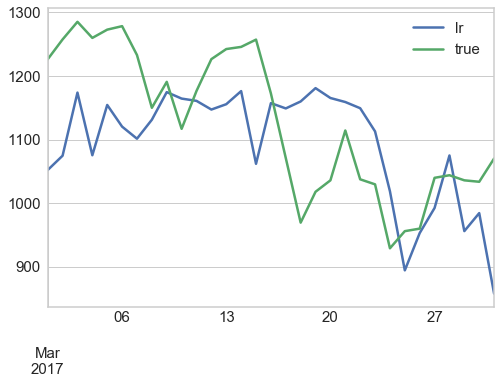

In [14]:
results.ix['2017-03-01':].plot()

#### Decision Tree and Random Forest

In [15]:
models = [DecisionTreeRegressor(max_depth = 35, random_state = 16),\
          RandomForestRegressor(n_estimators = 34, random_state = 16)]

#fig = plt.figure()
results = pd.DataFrame()
for index, model in enumerate(models):
    model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n Model MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred),np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis = 1)
    #fig.add_subplot(221+index)
    #pd.Series(model.feature_importances_, index = train.columns).plot(kind = 'barh')
        
results = pd.concat((results, y_val), axis=1)
results.columns = ['dt', 'rf', 'true']

0
 Model MAE: 192.323, RMSE: 244.921, MAPE: 35.315
1
 Model MAE: 159.647, RMSE: 223.657, MAPE: 28.454


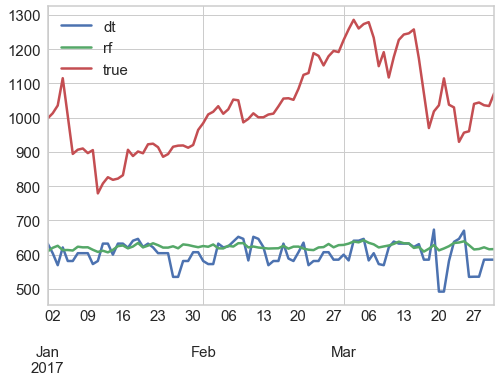

In [16]:
results.ix['2017-01-01':].plot()

#### Other models

In [17]:
models = [KNeighborsRegressor(n_neighbors = 25),\
          GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.025, max_depth = 10,\
                                    subsample = 0.75, random_state = 16)]

results = pd.DataFrame()
for index, model in enumerate(models):
    model = model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred), np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis = 1)
    
results = pd.concat((results, y_val), axis=1)
results.columns = ['knn', 'gbr', 'true']
# results['ens_mean'] = results[['knn', 'dt', 'lr', 'gbr', 'rf']].mean(axis=1)

0
 MAE: 330.761, RMSE: 395.251, MAPE: 112.315
1
 MAE: 179.835, RMSE: 243.405, MAPE: 33.305


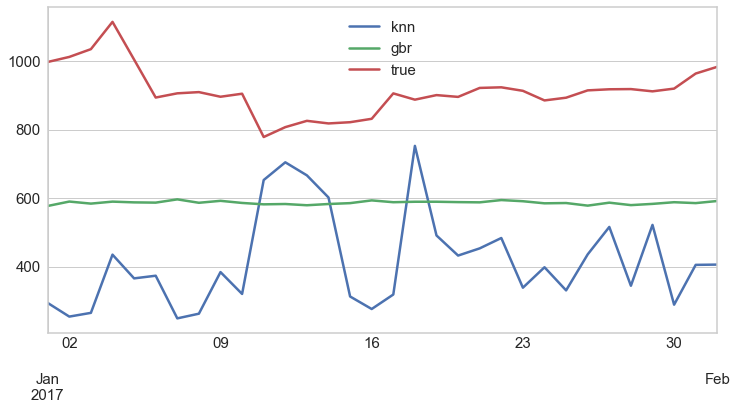

In [18]:
results.ix['2017-01-01':'2017-02-01'].plot(figsize = (12, 6))

### Target: Volume (BTC) variable

#### Preprocessing

In [19]:
df = df2.copy()
df = df.interpolate(method = 'linear')

df['dayofweek'] = df.index.map(lambda x: x.dayofweek)
df['doy'] = df.index.map(lambda x: x.dayofyear)
df['month'] = df.index.map(lambda x: x.month)
df['woy'] = df.index.map(lambda x: x.weekofyear)
df['qrt'] = df.index.map(lambda x: x.quarter)

df = pd.concat([df, df_presNYC, df_presLONDON, df_presRJTD], axis = 1)
df = df.ix['2013-01-01':]

start = '2016-01-01'
train = df[df.index < start]
val = df[start:]

In [20]:
y_train = train['Volume (BTC)']
y_val = val['Volume (BTC)']

del train['Volume (BTC)']
del val['Volume (BTC)']

#### Linear regression

In [21]:
models = [linear_model.LinearRegression(),\
          DecisionTreeRegressor(max_depth = 20, random_state = 16)]

results = pd.DataFrame()
for index, model in enumerate(models):
    model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n Model MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred),np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis = 1)
    
results = pd.concat((results, y_val), axis=1)
results.columns = ['lr', 'dt', 'true']

0
 Model MAE: 3321.397, RMSE: 5134.628, MAPE: 380.074
1
 Model MAE: 1260.931, RMSE: 2286.622, MAPE: 16.952


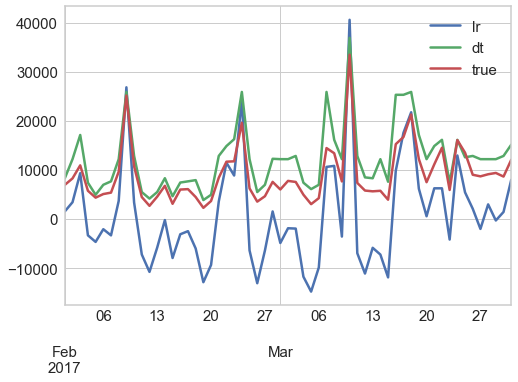

In [22]:
results.ix['2017-02-01':].plot()

#### Other models

In [23]:
models = [KNeighborsRegressor(n_neighbors = 5),\
          RandomForestRegressor(n_estimators = 10, random_state = 16),\
          GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.025, max_depth = 10,\
                                    subsample = 0.75, random_state = 16)]

results = pd.DataFrame()
for index, model in enumerate(models):
    model = model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred), np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis = 1)
    
results = pd.concat((results, y_val), axis=1)
results.columns = ['knn', 'rf', 'gbr', 'true']
# results['ens_mean'] = results[['knn', 'dt', 'lr', 'gbr', 'rf']].mean(axis=1)

0
 MAE: 6927.499, RMSE: 8379.777, MAPE: 53.739
1
 MAE: 1130.430, RMSE: 2095.597, MAPE: 15.486
2
 MAE: 1430.910, RMSE: 1719.172, MAPE: 23.578


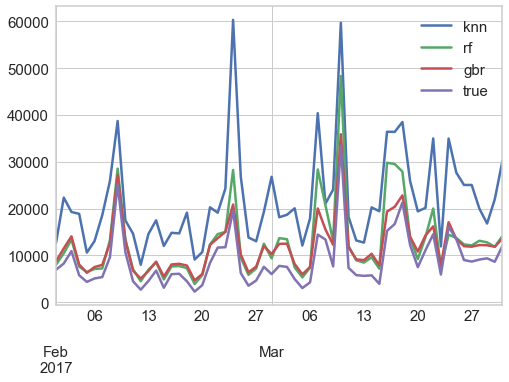

In [24]:
results.ix['2017-02-01':].plot()